In [2]:
# --------------- MAIN LIBRARIES ------------------

import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split


# --------------- HELPING LIBRARIES ----------------
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

# ------------- Pytorch Librairies ---------------
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
# from transformers import RobertaTokenizer, RobertaModel
from transformers import BertTokenizer, BertModel

In [3]:
train_dataset = 'train.csv'
test_dataset = 'test.csv'

# Check if the path exists
print (os.path.exists(train_dataset))
print (os.path.exists(test_dataset))

False
False


In [8]:
# Load the CSV file into a DataFrame
train_df = pd.read_csv(train_dataset, encoding='ISO-8859-1')
test_df = pd.read_csv(test_dataset, encoding='ISO-8859-1')

In [9]:
train_df.head(2)

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105


In [10]:
test_df.head(2)

,textID,text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral,morning,0-20,Afghanistan,38928346.0,652860.0,60.0
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive,noon,21-30,Albania,2877797.0,27400.0,105.0


In [11]:
def handle_null_values(df, columns_to_keep=None):
    """
    Handle null values in a pandas DataFrame.
    If missing values are less than 5%, remove rows with missing values.
    If missing values are 5% or more, keep rows where specified columns are not empty.

    Parameters:
    df (pd.DataFrame): The input DataFrame.
    columns_to_keep (list): List of column names to prioritize when keeping rows.

    Returns:
    pd.DataFrame: The DataFrame with null values handled.
    """

    # Calculate the percentage of missing values in the DataFrame
    missing_percentage = df.isnull().mean().mean() * 100

    print(f"Percentage of missing values in the dataset: {missing_percentage:.4f}%")

    # If missing values are less than 5%, remove rows with missing values
    if missing_percentage < 5:
        print("Missing values are less than 5%. Removing rows with missing values...")
        df_cleaned = df.dropna()
        print(f"Number of rows removed: {len(df) - len(df_cleaned)}")
    else:
        print("Missing values are 5% or more. Keeping rows where specified columns are not empty...")
        if columns_to_keep is None:
            print("No columns specified to keep. Returning the original DataFrame.")
            df_cleaned = df
        else:
            # Keep rows where the specified columns are not null
            df_cleaned = df.dropna(subset=columns_to_keep)
            print(f"Number of rows removed: {len(df) - len(df_cleaned)}")

    return df_cleaned

In [12]:
train_df = handle_null_values(train_df)

Percentage of missing values in the dataset: 0.0007%
Missing values are less than 5%. Removing rows with missing values...
Number of rows removed: 1


In [13]:
test_df=handle_null_values(test_df,columns_to_keep=["text","sentiment"])

Percentage of missing values in the dataset: 26.6044%
Missing values are 5% or more. Keeping rows where specified columns are not empty...
Number of rows removed: 1281


In [14]:
# Download necessary NLTK data
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [15]:
my_stopwords = stopwords.words('english').copy()

In [16]:
stopwords_to_keep = {
    'not', 'no', 'nor', "don't", "isn't", "aren't", "couldn't", "didn't", "doesn't",
    "hadn't", "hasn't", "haven't", "mightn't", "mustn't", "needn't", "shouldn't",
    "wasn't", "weren't", "won't", "wouldn't", 'but', 'however', 'although', 'though'
}

In [17]:
my_stopwords = list(set(my_stopwords) - stopwords_to_keep)
my_stopwords

['what',
 'he',
 'that',
 'a',
 'needn',
 'do',
 'i',
 "she'll",
 'down',
 'd',
 "should've",
 'being',
 'out',
 'can',
 'll',
 'don',
 'to',
 'up',
 'when',
 'her',
 'because',
 'are',
 'such',
 'their',
 'has',
 'were',
 "they'll",
 'while',
 'ma',
 'himself',
 'and',
 'only',
 'y',
 "they've",
 "i'm",
 'she',
 'themselves',
 'too',
 'theirs',
 'doing',
 'few',
 'further',
 'isn',
 'just',
 'on',
 'until',
 'most',
 'been',
 'which',
 'yours',
 'or',
 'itself',
 'ain',
 'above',
 "it'll",
 'where',
 't',
 'wouldn',
 'so',
 'some',
 'the',
 'in',
 "you'd",
 "you'll",
 'again',
 "he'd",
 'shouldn',
 'by',
 "i've",
 'hadn',
 'shan',
 'any',
 'wasn',
 'than',
 'all',
 "he's",
 'yourselves',
 'hers',
 'before',
 'had',
 'be',
 'we',
 'won',
 "she'd",
 've',
 'own',
 'here',
 'then',
 'mightn',
 'our',
 'very',
 'between',
 'once',
 're',
 'over',
 "we'd",
 'why',
 'how',
 'm',
 'whom',
 "they're",
 "shan't",
 'am',
 'weren',
 "she's",
 'herself',
 'those',
 'your',
 'if',
 'doesn',
 'they

In [18]:
import re

In [19]:
print(re.sub(r'\s+', ' ', "testing how,  this goes!   lol ?    "))

testing how, this goes! lol ? 


In [20]:
# Text preprocessing function that removes stopwords and converts text to lowercase

def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    stop_words = my_stopwords  # Using custom stopwords list called 'my_stopwords'
    # Remove stopwords from the text
    text = " ".join([word for word in text.split() if word not in stop_words])
    # Remove URLs (links starting with http or https)
    text = re.sub(r'https?://[A-Za-z0-9./_?=#]+', " ", text)
    # Remove all punctuation (anything that is not a letter, number, space, or some special symbols)
    text = re.sub(r"[^a-zA-Z0-9\s!?*$]", "", text)
    # Remove extra spaces (convert multiple spaces into a single space)
    text = re.sub(r'\s+', ' ', text)
    return text

In [21]:
# Apply preprocessing on train dataset
train_df['processed_text'] = train_df['text'].apply(preprocess_text)
train_df.head()

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²),processed_text
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60,id responded going
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105,sooo sad miss san diego!!!
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18,boss bullying me
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164,interview! leave alone
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26,sons **** couldnt put releases already bought


In [22]:
# Apply preprocessing on test dataset
test_df['processed_text'] = test_df['text'].apply(preprocess_text)
test_df.head()

,textID,text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²),processed_text
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral,morning,0-20,Afghanistan,38928346.0,652860.0,60.0,last session day
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive,noon,21-30,Albania,2877797.0,27400.0,105.0,shanghai also really exciting precisely skyscr...
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative,night,31-45,Algeria,43851044.0,2381740.0,18.0,recession hit veronique branquinho quit compan...
3,01082688c6,happy bday!,positive,morning,46-60,Andorra,77265.0,470.0,164.0,happy bday!
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive,noon,60-70,Angola,32866272.0,1246700.0,26.0,like it!!


In [23]:
# Transform sentiment into 3 classes
# Example mapping: positive -> 2, neutral -> 1, negative -> 0
sentiment_mapping = {"positive": 2, "neutral": 1, "negative": 0}
sentiment_reverse_mapping = {2: "positive",1:"neutral", 0:"negative"}
train_df["sentiment_class"] = train_df["sentiment"].map(sentiment_mapping)
test_df["sentiment_class"] = test_df["sentiment"].map(sentiment_mapping)

In [24]:
# Filters
negatives=train_df['sentiment']=="negative"
positives=train_df['sentiment']=="positive"
neutrals = train_df["sentiment"]=="neutral"

In [25]:
train_df["len"] = train_df["processed_text"].apply(lambda x: len(x.split()))

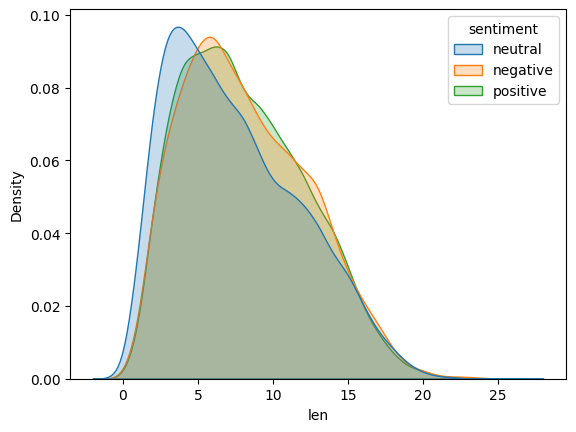

In [26]:
sns.kdeplot(data=train_df,x="len",hue="sentiment",fill=True, common_norm=False)
plt.show()

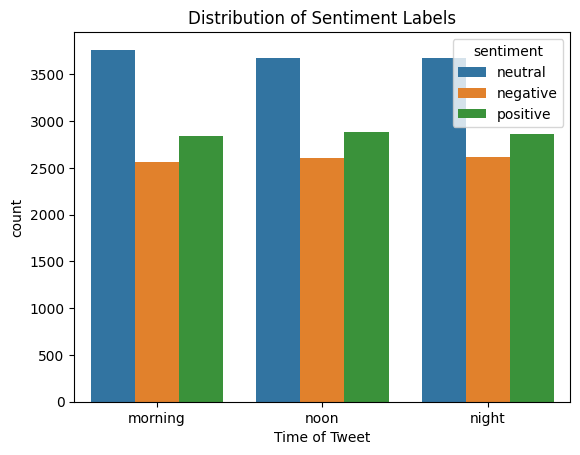

In [27]:
sns.countplot(x='Time of Tweet', data=train_df, hue="sentiment")
plt.title("Distribution of Sentiment Labels")
plt.show()


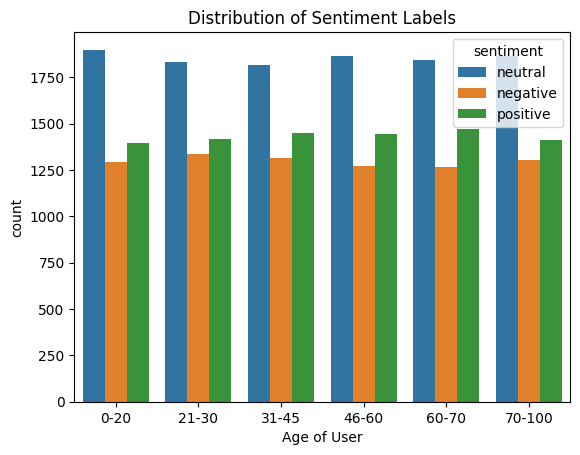

In [28]:
sns.countplot(x='Age of User', data=train_df, hue="sentiment")
plt.title("Distribution of Sentiment Labels")
plt.show()

In [29]:
from collections import Counter
top_pos =Counter(" ".join(train_df[positives]['processed_text']).split())
top_pos_df=pd.DataFrame(top_pos.most_common(100),columns=['Words','Counts'])

top_neg = Counter(" ".join(train_df[negatives]['processed_text']).split())
top_neg_df=pd.DataFrame(top_neg.most_common(100),columns=['Words','Counts'])

top_neu = Counter(" ".join(train_df[neutrals]['processed_text']).split())
top_neu_df=pd.DataFrame(top_neu.most_common(100),columns=['Words','Counts'])

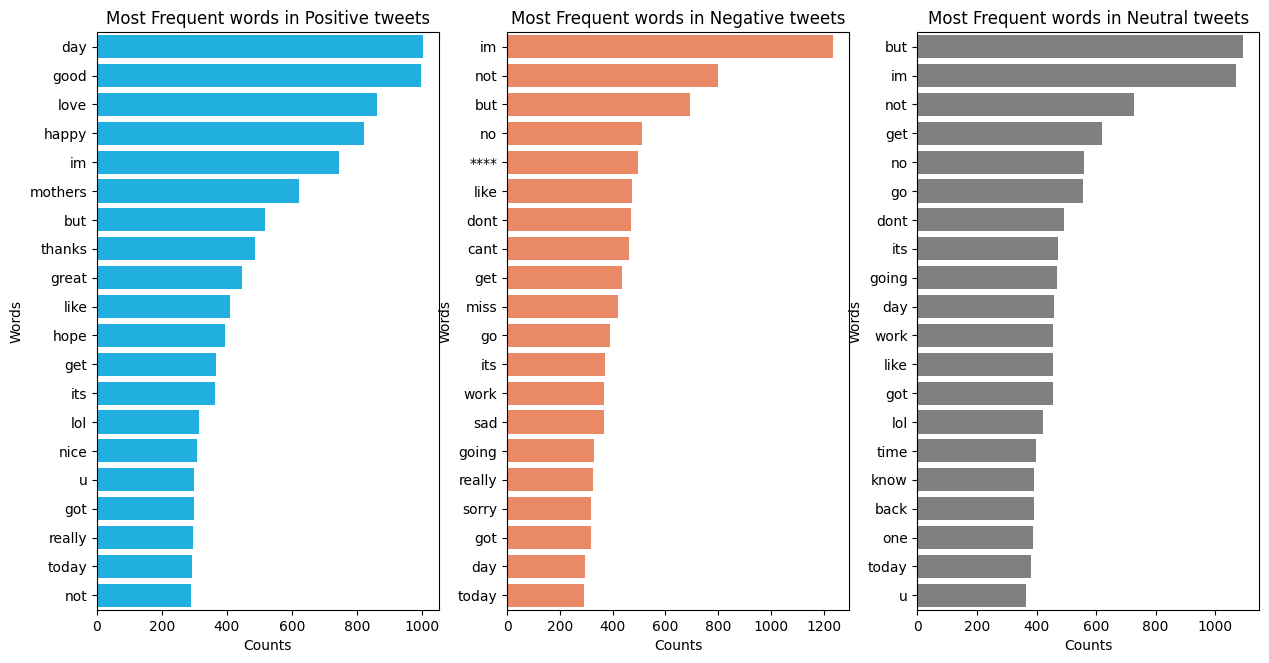

In [30]:
fig,ax=plt.subplots(nrows=1,ncols=3,figsize=(15,7.5))
sns.barplot(y='Words',x='Counts',data=top_pos_df[:20],color='deepskyblue',ax=ax[0])
sns.barplot(y='Words',x='Counts',data=top_neg_df[:20],color='coral',ax=ax[1])
sns.barplot(y='Words',x='Counts',data=top_neu_df[:20],color='grey',ax=ax[2])
ax[0].set_title("Most Frequent words in Positive tweets")
ax[1].set_title("Most Frequent words in Negative tweets")
ax[2].set_title("Most Frequent words in Neutral tweets")
plt.show()

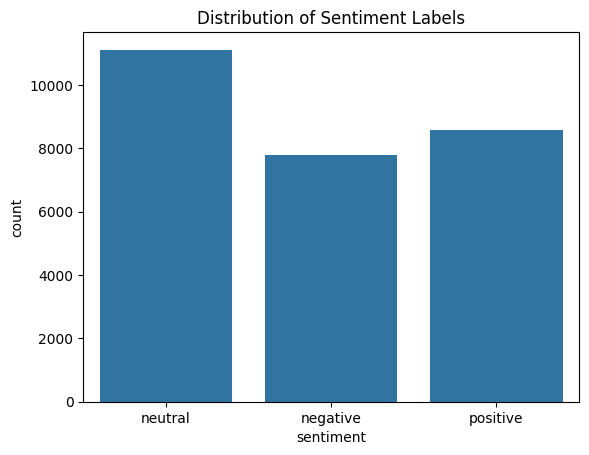

In [31]:
# Distribution of sentiment labels
sns.countplot(x='sentiment', data=train_df)
plt.title("Distribution of Sentiment Labels")
plt.show()

In [32]:
# Extract all the values from the 'processed_text' column into a list
trainval_x = train_df["processed_text"].tolist()
trainval_y = train_df["sentiment_class"].tolist()

train_x, val_x, train_y, val_y = train_test_split(trainval_x, trainval_y, test_size=0.2, random_state=1770)

test_x = test_df["processed_text"].tolist()
test_y = test_df["sentiment_class"].tolist()

Applying TF_IDF vectorization on classical ML models

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import  accuracy_score

In [34]:
tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=5,  # Ignore terms that appear in fewer than 5 documents
    max_df=0.95
)
X_train_tfidf = tfidf.fit_transform(train_df['processed_text'])
X_test_tfidf = tfidf.transform(test_df['processed_text'])

models = {
    'Logistic Regression': LogisticRegression(
        multi_class='multinomial',  # Specific for multi-class classification
        solver='lbfgs',
        max_iter=1000,
        class_weight='balanced'
    ),
    'Naive Bayes': MultinomialNB(alpha=0.1),  # Adding a smoothing parameter
    'Linear SVM': LinearSVC(
        multi_class='ovr',  # One-vs-Rest
        max_iter=1000,
        class_weight='balanced'
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=100,
        class_weight='balanced',
        max_depth=10  # Limit depth to prevent overfitting
    )
}

results_tf = {}
for name, model in models.items():
    model.fit(X_train_tfidf, train_df["sentiment_class"])
    y_pred = model.predict(X_test_tfidf)
    accuracy = accuracy_score(test_df["sentiment_class"], y_pred)
    results_tf[name] = {
        'accuracy': accuracy,
    }

for name in models.keys():
    print(f"\nResults for {name}:")
    print(f"Accuracy: {results_tf[name]['accuracy']:.4f}")


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Results for Logistic Regression:
Accuracy: 0.7049

Results for Naive Bayes:
Accuracy: 0.6338

Results for Linear SVM:
Accuracy: 0.6916

Results for Random Forest:
Accuracy: 0.6488


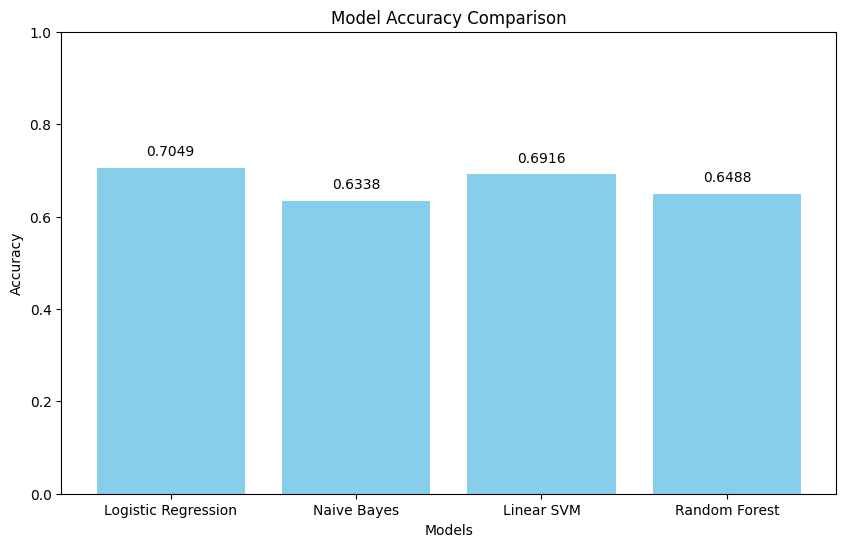

In [35]:
model_names = list(results_tf.keys())
accuracies = [results_tf[name]["accuracy"] for name in model_names]

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracies, color="skyblue")

# Add labels and title
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.ylim(0, 1)  # Set y-axis limit between 0 and 1 for accuracy

# Add accuracy values on top of the bars
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.02, f"{acc:.4f}", ha="center", va="bottom")

# Show the plot
plt.show()


Loading the dataset into pytorch Dataset with embeddings

In [36]:
from tqdm import tqdm
class TextDatasetWithEmbeddings(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length, model, device):
        """
        Args:
            texts (list): List of text samples.
            labels (list): List of labels.
            tokenizer (transformers.BertTokenizer): BERT tokenizer.
            max_length (int): Maximum sequence length.
            model (transformers.BertModel): Pre-trained BERT model.
            device (torch.device): Device (CPU/GPU).
            use_pooler (bool): If True, use `pooler_output`; else, use `last_hidden_state[:, 0, :]`.
        """
        self.texts = texts
        self.labels = torch.tensor(labels, dtype=torch.long)
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.model = model
        self.device = device

        # Tokenize all texts upfront
        self.encodings = self.tokenizer(
            texts,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )

        # Precompute embeddings for all texts
        self.embeddings = self._precompute_embeddings()

    def _precompute_embeddings(self, batch_size=512):
        """Generates embeddings in batches to avoid GPU memory overload."""
        print("Generating embeddings in batches...")
        self.model.eval()
        self.model.to(self.device)

        # Get total number of samples
        num_samples = self.encodings["input_ids"].size(0)

        # Initialize tensor to store all embeddings
        all_embeddings = []

        # Process in batches
        for start_idx in tqdm(range(0, num_samples, batch_size)):
            end_idx = min(start_idx + batch_size, num_samples)

            # Get batch
            batch_input_ids = self.encodings["input_ids"][start_idx:end_idx].to(self.device)
            batch_attention_mask = self.encodings["attention_mask"][start_idx:end_idx].to(self.device)

            with torch.no_grad():
                outputs = self.model(
                    input_ids=batch_input_ids,
                    attention_mask=batch_attention_mask
                )
                batch_embeddings = outputs.pooler_output
            all_embeddings.append(batch_embeddings.cpu())

        # Combine all batches
        return torch.cat(all_embeddings, dim=0)

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        """Returns precomputed embeddings and labels."""
        return self.embeddings[idx], self.labels[idx]

In [37]:
class TokenizedDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.encodings = tokenizer(texts, padding=True, truncation=True, max_length=max_length, return_tensors="pt")
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {key: val[idx] for key, val in self.encodings.items()}, self.labels[idx]

initializations of datasets/dataloaders

In [38]:
MAX_LENGTH = 128
PRETRAINED_MODEL = "bert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = BertTokenizer.from_pretrained(PRETRAINED_MODEL)
bert = BertModel.from_pretrained(PRETRAINED_MODEL).to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Tokenized Dataset

In [39]:
train_dataset_tokenized = TokenizedDataset(train_x, train_y, tokenizer, MAX_LENGTH)
val_dataset_tokenized = TokenizedDataset(val_x, val_y, tokenizer, MAX_LENGTH)
test_dataset_tokenized = TokenizedDataset(test_x, test_y, tokenizer, MAX_LENGTH)

Embedded Dataset

In [40]:
train_dataset_embed =  TextDatasetWithEmbeddings(
        texts=train_x,
        labels=train_y,
        tokenizer=tokenizer,
        max_length=MAX_LENGTH,
        model=bert,
        device=device
    )

val_dataset_embed = TextDatasetWithEmbeddings(
        texts=val_x,
        labels=val_y,
        tokenizer=tokenizer,
        max_length=MAX_LENGTH,
        model=bert,
        device=device
    )

test_dataset_embed = TextDatasetWithEmbeddings(
        texts=test_x,
        labels=test_y,
        tokenizer=tokenizer,
        max_length=MAX_LENGTH,
        model=bert,
        device=device
    )

Generating embeddings in batches...


100%|██████████| 43/43 [02:26<00:00,  3.41s/it]


Generating embeddings in batches...


100%|██████████| 11/11 [00:37<00:00,  3.43s/it]


Generating embeddings in batches...


100%|██████████| 7/7 [00:24<00:00,  3.48s/it]


In [41]:
# Batch size
BATCH_SIZE_TRAIN = 64
BATCH_SIZE_TEST = 256

Tokenized Dataloader

In [42]:
train_loader_tokenized = DataLoader(train_dataset_tokenized
, batch_size=BATCH_SIZE_TRAIN, shuffle=True)
valloader_tokenized = DataLoader(val_dataset_tokenized, batch_size=BATCH_SIZE_TEST, shuffle=True)
testloader_tokenized = DataLoader(test_dataset_tokenized, batch_size = BATCH_SIZE_TEST,shuffle=False)

In [48]:
# Function to test the ML models
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.patches as patches

def test_ml_model(model, model_name, test_dataset=test_dataset_embed, validation_dataset=val_dataset_embed):
    # Make predictions
    test_label_pred = model.predict(test_dataset.embeddings.numpy())
    validation_label_pred = model.predict(validation_dataset.embeddings.numpy())

    # Compute confusion matrices
    cm_test = confusion_matrix(test_dataset.labels.numpy(), test_label_pred)
    cm_validation = confusion_matrix(validation_dataset.labels.numpy(), validation_label_pred)

    # Set up the subplots
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # 1 row, 2 columns

    # Plot test confusion matrix
    sns.heatmap(cm_test, annot=True, fmt="d", cbar=True,
                xticklabels=list(sentiment_reverse_mapping.values()),
                yticklabels=list(sentiment_reverse_mapping.values()), ax=axes[0])
    axes[0].set_title("Test Confusion Matrix")
    axes[0].set_xlabel("Predicted Labels")
    axes[0].set_ylabel("True Labels")

    # Highlight the diagonal (correct predictions) for test set
    for i in range(cm_test.shape[0]):
        axes[0].add_patch(patches.Rectangle((i, i), 1, 1, fill=False, edgecolor="Coral", linewidth=2))

    # Plot validation confusion matrix
    sns.heatmap(cm_validation, annot=True, fmt="d", cbar=True,
                xticklabels=list(sentiment_reverse_mapping.values()),
                yticklabels=list(sentiment_reverse_mapping.values()), ax=axes[1])
    axes[1].set_title("Validation Confusion Matrix")
    axes[1].set_xlabel("Predicted Labels")
    axes[1].set_ylabel("True Labels")

    # Highlight the diagonal (correct predictions) for validation set
    for i in range(cm_validation.shape[0]):
        axes[1].add_patch(patches.Rectangle((i, i), 1, 1, fill=False, edgecolor="Coral", linewidth=2))

    # Show the plot
    plt.tight_layout()
    plt.show()

    # Get classification report as dictionary
    test_report = classification_report(test_dataset.labels.numpy(), test_label_pred, output_dict=True)
    validation_report = classification_report(validation_dataset.labels.numpy(), validation_label_pred, output_dict=True)

    # Print classification reports
    print("Test Classification Report:")
    print(f"Overall Score {(model.score(test_dataset.embeddings.numpy(), test_dataset.labels.numpy()) * 100):.2f}%")
    print(classification_report(test_dataset.labels.numpy(), test_label_pred))

    print("Validation Classification Report:")
    print(f"Overall Score {(model.score(validation_dataset.embeddings.numpy(), validation_dataset.labels.numpy()) * 100):.2f}%")
    print(classification_report(validation_dataset.labels.numpy(), validation_label_pred))

    # Extract key metrics
    metrics = {
        "model_name": model_name,
        "test_accuracy": test_report["accuracy"],
        "test_precision": test_report["weighted avg"]["precision"],
        "test_recall": test_report["weighted avg"]["recall"],
        "test_f1-score": test_report["weighted avg"]["f1-score"],
        "validation_accuracy": validation_report["accuracy"],
        "validation_precision": validation_report["weighted avg"]["precision"],
        "validation_recall": validation_report["weighted avg"]["recall"],
        "validation_f1-score": validation_report["weighted avg"]["f1-score"],
    }

    return metrics

In [50]:
results = []

In [51]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=42)
dt.fit(train_dataset_embed.embeddings.numpy(),train_dataset_embed.labels.numpy())

DecisionTreeClassifier(random_state=42)

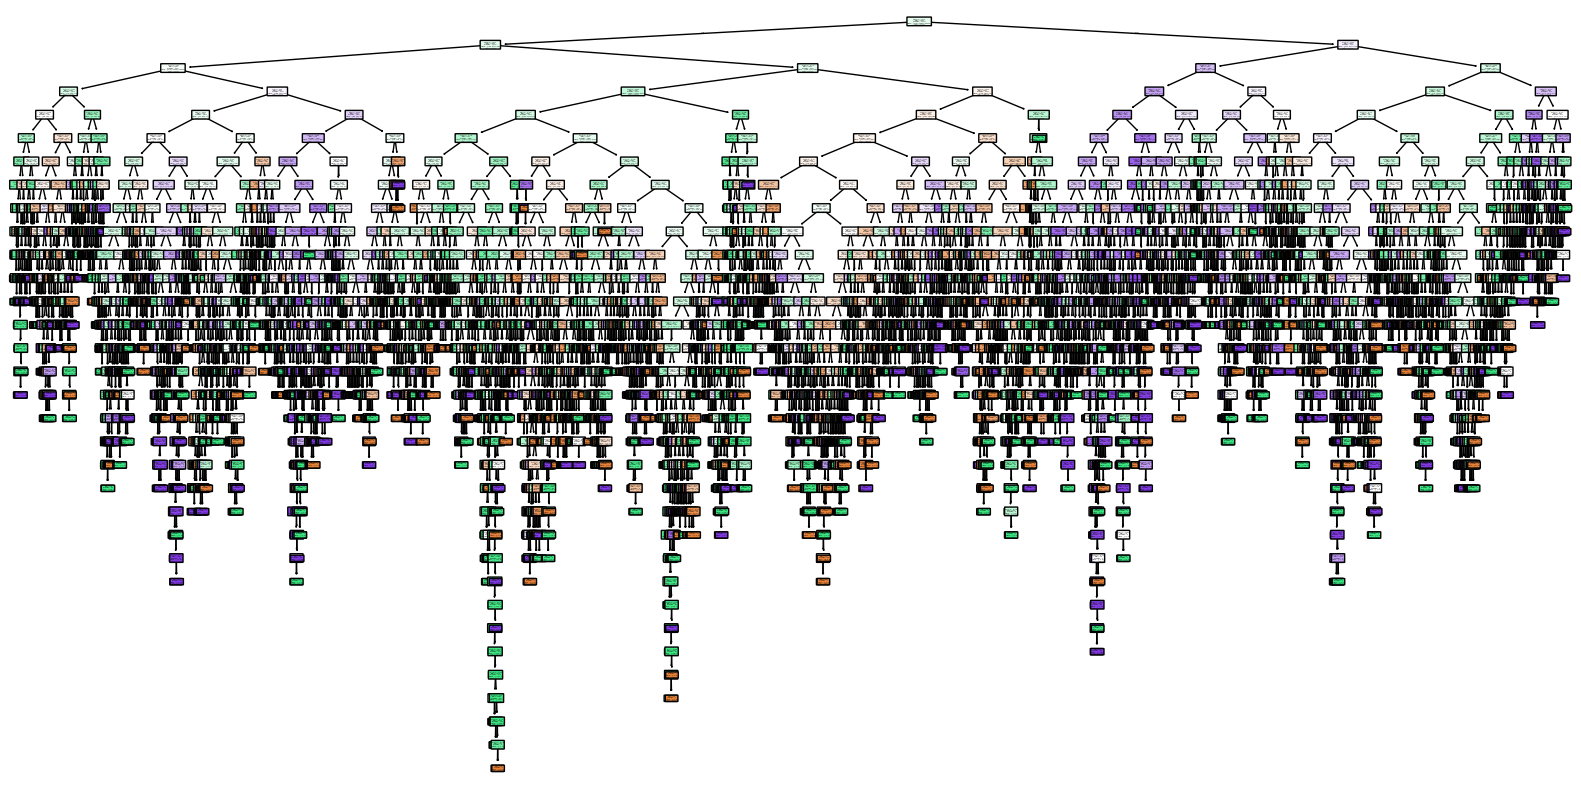

In [52]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plot_tree(dt, filled=True, feature_names=None, class_names=['negative', 'neutral', 'positive'], rounded=True)
plt.show()

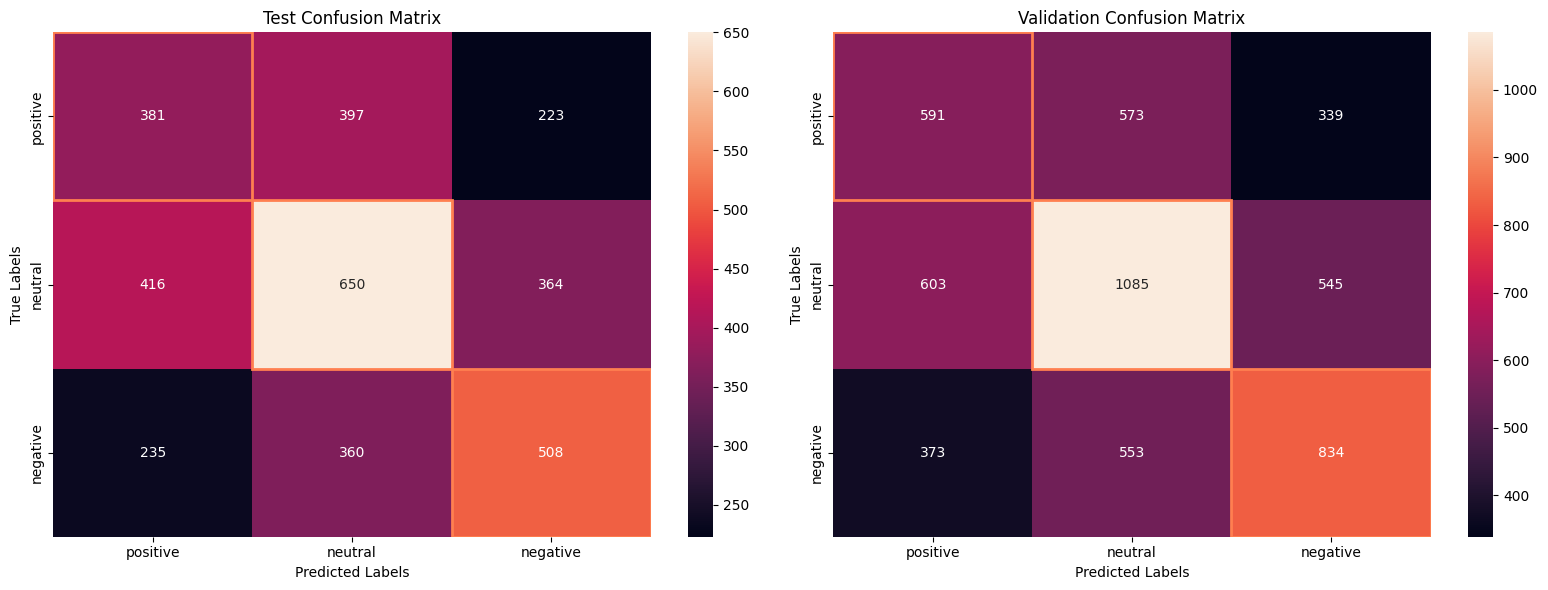

Test Classification Report:
Overall Score 43.55%
              precision    recall  f1-score   support

           0       0.37      0.38      0.37      1001
           1       0.46      0.45      0.46      1430
           2       0.46      0.46      0.46      1103

    accuracy                           0.44      3534
   macro avg       0.43      0.43      0.43      3534
weighted avg       0.44      0.44      0.44      3534

Validation Classification Report:
Overall Score 45.67%
              precision    recall  f1-score   support

           0       0.38      0.39      0.39      1503
           1       0.49      0.49      0.49      2233
           2       0.49      0.47      0.48      1760

    accuracy                           0.46      5496
   macro avg       0.45      0.45      0.45      5496
weighted avg       0.46      0.46      0.46      5496



In [53]:
results.append(test_ml_model(dt,"Decision Tree"))

In [54]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100,random_state=42,verbose = True)
rf.fit(train_dataset_embed.embeddings.numpy(),train_dataset_embed.labels.numpy())

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   52.1s


RandomForestClassifier(random_state=42, verbose=True)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s


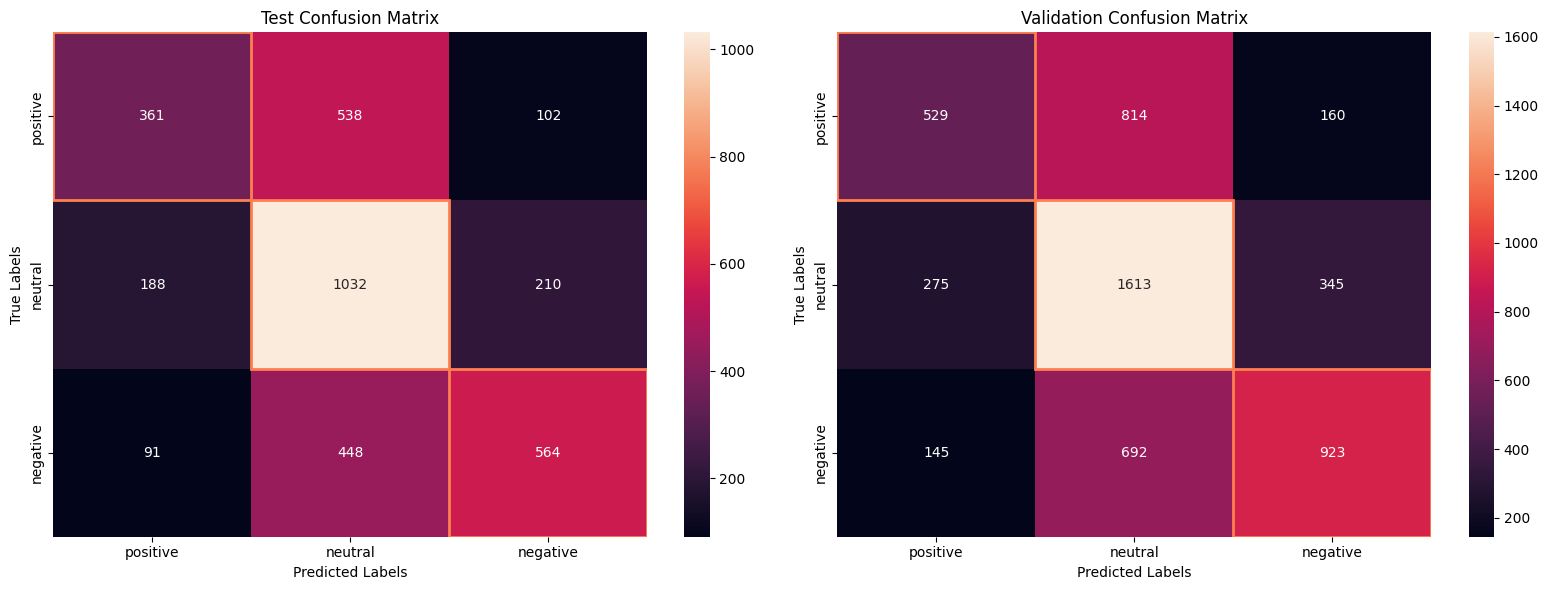

Test Classification Report:
Overall Score 55.38%
              precision    recall  f1-score   support

           0       0.56      0.36      0.44      1001
           1       0.51      0.72      0.60      1430
           2       0.64      0.51      0.57      1103

    accuracy                           0.55      3534
   macro avg       0.57      0.53      0.54      3534
weighted avg       0.57      0.55      0.54      3534

Validation Classification Report:


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s


Overall Score 55.77%
              precision    recall  f1-score   support

           0       0.56      0.35      0.43      1503
           1       0.52      0.72      0.60      2233
           2       0.65      0.52      0.58      1760

    accuracy                           0.56      5496
   macro avg       0.57      0.53      0.54      5496
weighted avg       0.57      0.56      0.55      5496



In [55]:
results.append(test_ml_model(rf,"Random Forest"))

In [56]:
from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import GridSearchCV
# param_grid = {'C': [0.001,0.01,0.1,1,2,3]}

LR = LogisticRegression(max_iter=1000)
LR.fit(train_dataset_embed.embeddings.numpy(),train_dataset_embed.labels.numpy())
# grid_search = GridSearchCV(estimator=LR, param_grid=param_grid)
# grid_search.fit(train_dataset_embed.embeddings.numpy(),train_dataset_embed.labels.numpy())
# LR= grid_search.best_estimator_
# print(grid_search.best_params_["C"])

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000)

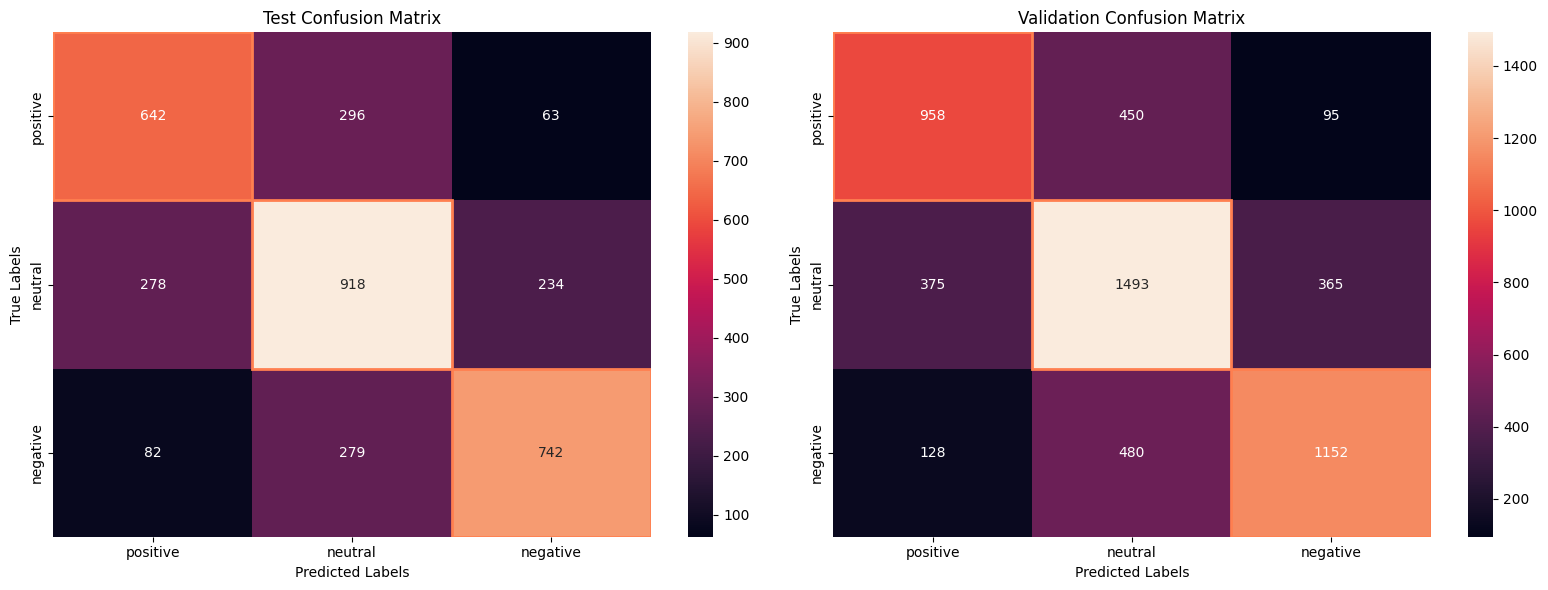

Test Classification Report:
Overall Score 65.14%
              precision    recall  f1-score   support

           0       0.64      0.64      0.64      1001
           1       0.61      0.64      0.63      1430
           2       0.71      0.67      0.69      1103

    accuracy                           0.65      3534
   macro avg       0.66      0.65      0.65      3534
weighted avg       0.65      0.65      0.65      3534

Validation Classification Report:
Overall Score 65.56%
              precision    recall  f1-score   support

           0       0.66      0.64      0.65      1503
           1       0.62      0.67      0.64      2233
           2       0.71      0.65      0.68      1760

    accuracy                           0.66      5496
   macro avg       0.66      0.65      0.66      5496
weighted avg       0.66      0.66      0.66      5496



In [57]:
results.append(test_ml_model(LR,"Logistic Regression"))

In [58]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=30)
knn.fit(train_dataset_embed.embeddings.numpy(),train_dataset_embed.labels.numpy())

KNeighborsClassifier(n_neighbors=30)

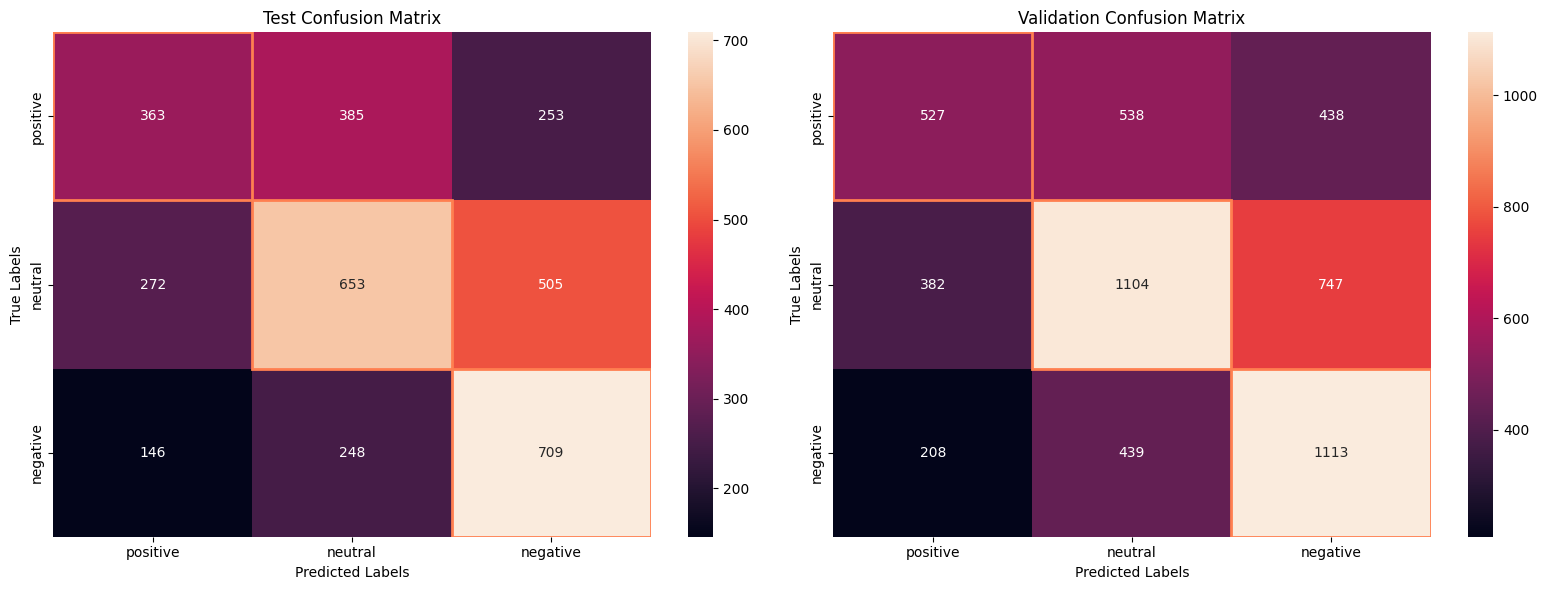

Test Classification Report:
Overall Score 48.81%
              precision    recall  f1-score   support

           0       0.46      0.36      0.41      1001
           1       0.51      0.46      0.48      1430
           2       0.48      0.64      0.55      1103

    accuracy                           0.49      3534
   macro avg       0.49      0.49      0.48      3534
weighted avg       0.49      0.49      0.48      3534

Validation Classification Report:
Overall Score 49.93%
              precision    recall  f1-score   support

           0       0.47      0.35      0.40      1503
           1       0.53      0.49      0.51      2233
           2       0.48      0.63      0.55      1760

    accuracy                           0.50      5496
   macro avg       0.50      0.49      0.49      5496
weighted avg       0.50      0.50      0.49      5496



In [59]:
results.append(test_ml_model(knn,"KNeighbors(k=30)"))

In [60]:
from sklearn.naive_bayes import GaussianNB
GNB  =  GaussianNB(var_smoothing=1e-2)
GNB .fit(train_dataset_embed.embeddings.numpy(),train_dataset_embed.labels.numpy())


GaussianNB(var_smoothing=0.01)

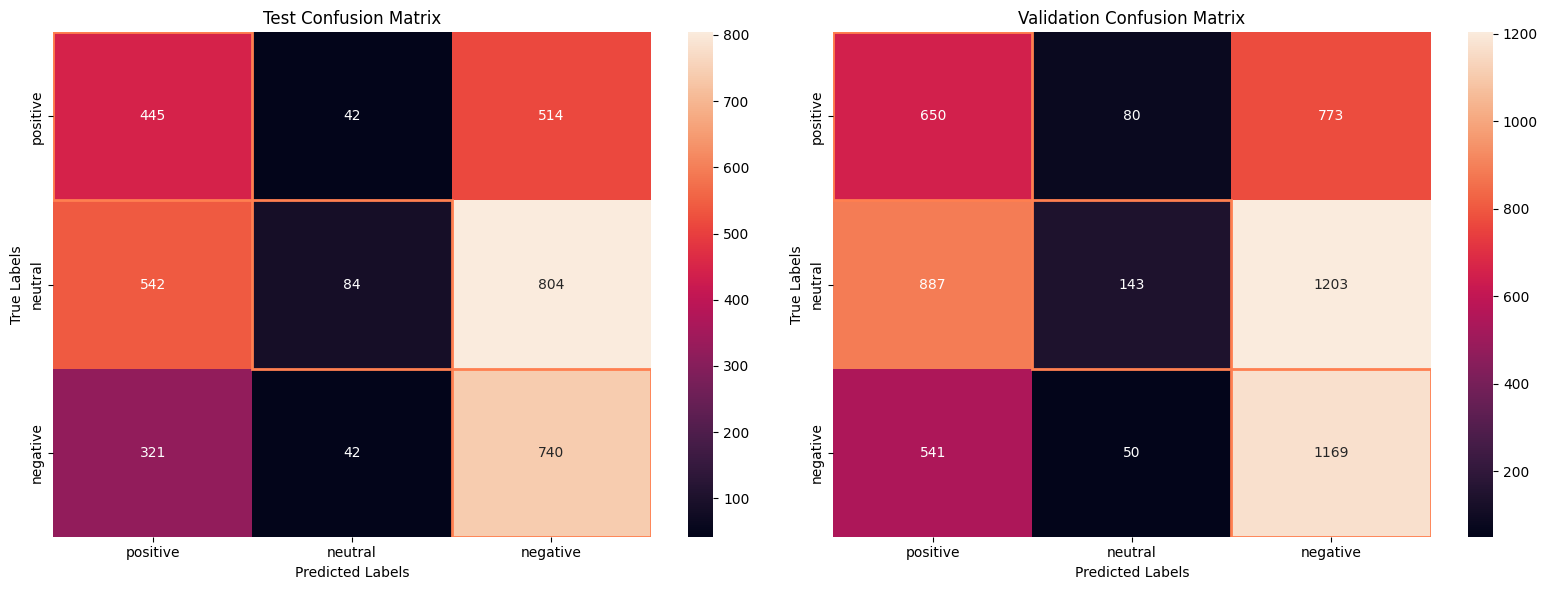

Test Classification Report:
Overall Score 35.91%
              precision    recall  f1-score   support

           0       0.34      0.44      0.39      1001
           1       0.50      0.06      0.11      1430
           2       0.36      0.67      0.47      1103

    accuracy                           0.36      3534
   macro avg       0.40      0.39      0.32      3534
weighted avg       0.41      0.36      0.30      3534

Validation Classification Report:
Overall Score 35.70%
              precision    recall  f1-score   support

           0       0.31      0.43      0.36      1503
           1       0.52      0.06      0.11      2233
           2       0.37      0.66      0.48      1760

    accuracy                           0.36      5496
   macro avg       0.40      0.39      0.32      5496
weighted avg       0.42      0.36      0.30      5496



In [61]:
results.append(test_ml_model(GNB, "Gaussian Naive Bayes"))